In [2]:
# ---- LIBRARY IMPORTS ----
import pandas as pd
import datetime
import requests
from datetime import datetime
from haversine import haversine

In [3]:
# ---- Reading in datasets ----
usecols = [index for index in range(1, 14)]
dtype = {'ride_id': "string", 'rideable_type': "string", 'started_at': "string", 'ended_at': "string", 'start_station_name': "string",
         'start_station_id': "string", 'end_station_name': "string", 'end_station_id': "string", 'start_lat': float,
         'start_lng': float, 'end_lat': float, 'end_lng': float, 'member_casual': "string"}
df = pd.read_csv('data/202407-citibike-tripdata_5.csv', usecols=usecols, dtype=dtype)

In [4]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,557426B1CE207702,electric_bike,2024-07-17 19:30:15.471,2024-07-17 19:34:22.646,Sullivan St & Washington Sq,5721.01,E 12 St & 3 Ave,5788.12,40.730477,-73.999061,40.732233,-73.988900,member
1,A60E366FEE8B51E8,electric_bike,2024-07-15 19:17:52.523,2024-07-15 19:25:24.399,Sullivan St & Washington Sq,5721.01,Forsyth St & Grand St,5382.07,40.730477,-73.999061,40.717798,-73.993161,member
2,ACA30207F80B5DF9,classic_bike,2024-07-27 13:34:48.531,2024-07-27 13:49:55.913,W 37 St & 10 Ave,6611.02,Perry St & Bleecker St,5922.07,40.756604,-73.997901,40.735354,-74.004831,member
3,B3A138C956E9A729,electric_bike,2024-07-23 11:01:36.895,2024-07-23 11:06:02.796,Melrose St & Broadway,4801.04,Nostrand Ave & Myrtle Ave,4707.04,40.697481,-73.935877,40.695270,-73.952381,member
4,EA0BFE3B299B0672,electric_bike,2024-07-16 19:19:15.034,2024-07-16 19:50:39.140,Melrose St & Broadway,4801.04,W 27 St & 7 Ave,6257.06,40.697481,-73.935877,40.746650,-73.993920,member


# Data Cleansing
The following operations are required for data cleaning

1. Encode `rideable_type` and `member_casual`
2. Create fields for `start_date`, `start_time`, `end_date`, `end_time`
3. Create field for trip duration
4. Create distance between stations using the [Manhattan's Distance](https://www.datacamp.com/tutorial/manhattan-distance)
5. Drop any rows with missing station IDs

## Encoding Binary Variables
The `rideable_type` and `member_casual` fields will use dummy encoding using pandas' [`get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) method.

In [5]:
df = pd.get_dummies(data=df, columns=['rideable_type', 'member_casual'], dtype="int", drop_first=True)

## Drop any NA values
We want to drop any values with `Null` for missing station IDs, names, ride IDs, coordinates or names because if any of them are `Null`, then we cannot understand what what on during a ride.

In [6]:
df.dropna(subset=['ride_id', 'started_at', 'ended_at', 'start_station_name', 'start_station_id',
                  'end_station_id', 'end_station_name', 'start_lat', 'end_lat', 'end_lng', 'end_lng'], inplace=True)

## Create fields for `start_date`, `start_time`, `end_date`, `end_time`

In [7]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
date_map = lambda val: val.date()
time_map = lambda val: val.time()
df['start_date'] = df['started_at'].map(date_map)
df['end_date'] = df['ended_at'].map(date_map)
df['start_time'] =  df['started_at'].map(time_map)
df['end_time'] = df['ended_at'].map(time_map)

## Create field for trip_duration
We will now create the `trip_duration` field that describes the trip duration 

In [8]:
trip_duration = df['ended_at'] - df['started_at']
get_trip_seconds = lambda val: val.total_seconds()
df['trip_duration'] = trip_duration.map(get_trip_seconds)

## Get Distance Between All Stations
We now will capture the distances between all stations using the [Haversine Distance](https://pypi.org/project/haversine/), in meters.

In [9]:
def haversine_map(row):
    start_coordinates = (row['start_lat'], row['start_lng'])
    end_coordinates = (row['end_lat'], row['end_lng'])
    dist = haversine(start_coordinates, end_coordinates, unit="m")
    return dist

df['ride_dist'] = df.apply(haversine_map, axis=1)

# Analyze, Model, and Visualize
We aim to answer the below questions.

1. Which borough has the most bikes?
2. When are bikers most actively riding bikes?
3. Is there a significant difference in the average travel time between electric bikes and mechanical bikes?
4. Which pairs of stations have the highest activity, that is, which stations have the most bikers traveling between them?
5. Can we guess the trip time of a biker?



## Question One
_Which stations cause long trip times?_

<Axes: xlabel='start_station_id'>

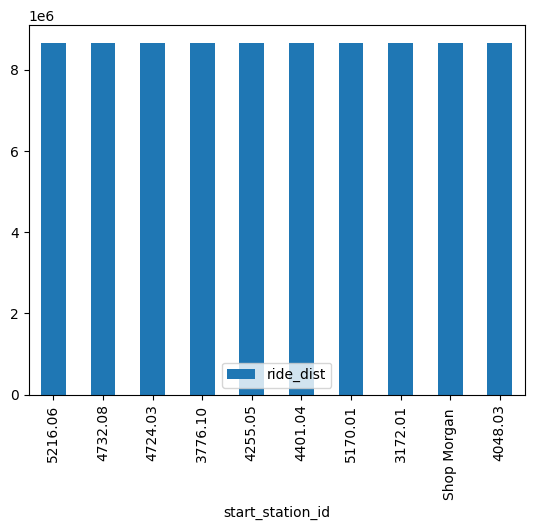

In [25]:
df[["start_station_id", "ride_dist"]].groupby(by="start_station_id").max().sort_values(by="ride_dist", ascending=False).head(10).plot.bar()

In [26]:
df[["start_station_id", "ride_dist"]].groupby(by="start_station_id").max().sort_values(by="ride_dist", ascending=False).head(10)

,ride_dist
start_station_id,
5216.06,8.667439e+06
4732.08,8.664100e+06
4724.03,8.663549e+06
3776.10,8.662211e+06
4255.05,8.662144e+06
4401.04,8.661691e+06
5170.01,8.661049e+06
3172.01,8.661033e+06
Shop Morgan,8.660856e+06


## Question Two
_When are bikers most actively riding bikes?_

In order to find when bikers are most active, we will show categorize each ride's `start_time` field into morning, afternoon, evening, and night.  The hours of of these times of days are defined [here](https://www.britannica.com/dictionary/eb/qa/parts-of-the-day-early-morning-late-morning-etc)

|Part of Day|Time Interval|
|:---:|:---:|
|Morning|05:00:00 - 11:59:59|
|Afternoon|12:00:00 - 16:59:59|
|Evening|17:00:00 - 20:59:59|
|Night|21:00:00 - 04:59:59|

In [10]:
def time_categorizer(row):
    start_time = row['start_time']
    hour = start_time.hour
    if hour > 4 and hour < 12: 
        time_of_day = "morning"
    elif hour > 11 and hour < 17:
        time_of_day = "afternoon"
    elif hour > 16 and hour < 21:
        time_of_day = "evening"
    else:
        time_of_day = "night"
    return time_of_day
    
df['time_of_day'] = df.apply(time_categorizer, axis=1)

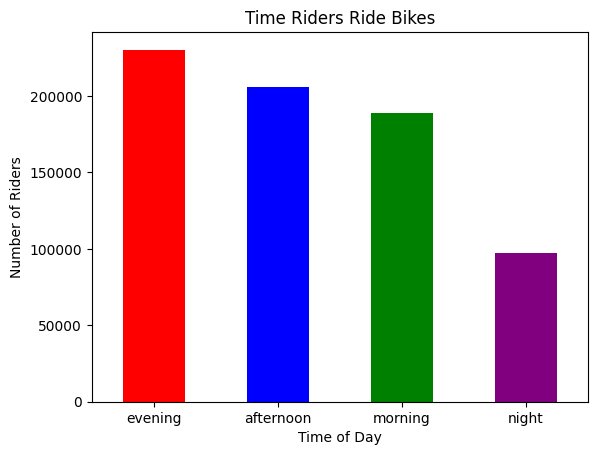

In [12]:
time_of_day_counts = df['time_of_day'].value_counts()
colors = ['red', 'blue', 'green', 'purple']
time_riders_ride_plot = time_of_day_counts.plot.bar(color=colors, rot=0, title="Time Riders Ride Bikes", xlabel="Time of Day", ylabel="Number of Riders")
time_riders_ride_plot.get_figure().savefig("img/time_riders_ride_bike_graph.png")

In [14]:
df.columns

Index(['ride_id', 'started_at', 'ended_at', 'start_station_name',
       'start_station_id', 'end_station_name', 'end_station_id', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'rideable_type_electric_bike',
       'member_casual_member', 'start_date', 'end_date', 'start_time',
       'end_time', 'trip_duration', 'ride_dist', 'time_of_day'],
      dtype='object')